In [72]:
%matplotlib inline

import numpy as np
import tensorflow as tf

from seq2seq import graph_utils
from seq2seq.inference import create_inference_graph, create_predictions_iter
from seq2seq.inference import print_translations
from seq2seq.data import data_utils
from seq2seq.training import utils as training_utils

from matplotlib import pyplot as plt

tf.logging.set_verbosity(tf.logging.DEBUG)

In [73]:
MODEL_CLASS = "AttentionSeq2Seq"
MODEL_DIR = "/Users/dennybritz/Downloads/toy"
INPUT_FILE = "/tmp/toydata/train/sources.txt"
VOCAB_SOURCE = "/tmp/toydata/train/vocab.txt"
VOCAB_TARGET = "/tmp/toydata/train/vocab.txt"

In [74]:
# Create the model graph
tf.reset_default_graph()
predictions, _, _ = create_inference_graph(
    model_class="AttentionSeq2Seq",
    model_dir=MODEL_DIR,
    input_file=INPUT_FILE,
    vocab_source=VOCAB_SOURCE,
    vocab_target=VOCAB_TARGET,
    batch_size=32)
vocab_tables = graph_utils.get_dict_from_collection("vocab_tables")
features = graph_utils.get_dict_from_collection("features")

INFO:tensorflow:Creating vocabulary lookup table of size 23
INFO:tensorflow:Creating vocabulary lookup table of size 23


In [75]:
# Initialize the session and restore the checkpoint
saver = tf.train.Saver()
checkpoint_path = tf.train.latest_checkpoint(MODEL_DIR)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
sess.run(tf.initialize_all_tables())

saver.restore(sess, checkpoint_path)
tf.logging.info("Restored model from %s", checkpoint_path)

INFO:tensorflow:Restored model from /Users/dennybritz/Downloads/toy/model.ckpt-1318


In [76]:
# Create an iterator of predictions with some extra information
predictions["source_tokens"] = features["source_tokens"]
predictions["source_len"] = features["source_len"]
predictions["target_words"] = vocab_tables["target_id_to_vocab"].lookup(predictions["predictions"])                        
predictions_iter = create_predictions_iter(predictions, sess)

In [77]:
# Get the next predictions
pred_ = next(predictions_iter)

Source: 15 9 7 17 0 14 19 8 5 12 14 15 18 19 0 8 13 15 SEQUENCE_END
Target: 15 7 8 0 0 19 18 15 14 12 5 8 19 14 0 17 SEQUENCE_END


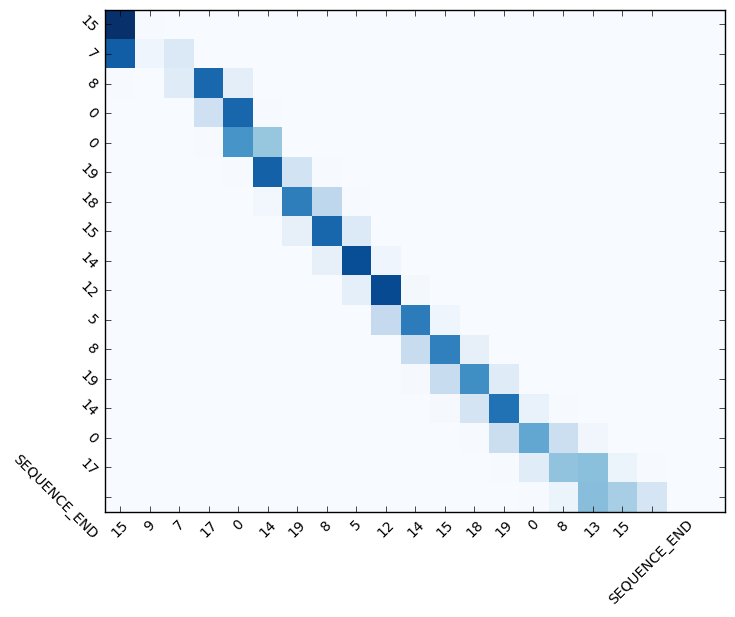

In [78]:
# Find out how long the predicted sequence is
target_words = [_.decode() for _ in pred_["target_words"]]
if "SEQUENCE_END" in target_words:
  prediction_len = target_words.index("SEQUENCE_END") + 1
else:
  prediction_len = None
target_words = target_words[:prediction_len]
  
# Get source words
source_len = pred_["source_len"]
source_words = [_.decode() for _ in pred_["source_tokens"][:source_len]]

print("Source: " + " ".join(source_words))
print("Target: " + " ".join(target_words))
  
# Plot
plt.figure(figsize=(8,8))
plt.imshow(pred_["attention_scores"][:prediction_len,:], interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(np.arange(source_len), source_words, rotation=45)
plt.yticks(np.arange(prediction_len), target_words, rotation=-45)
None